<a href="https://colab.research.google.com/github/nxf-emma/APS360-Artificial-Intelligence-Fundamentals/blob/main/resnet_learning_rate_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# train

In [4]:
def get_accuracy(model, dataloader):
    

    correct = 0
    total = 0
    for imgs, labels in dataloader:
        
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
#Convolutional Neural Network Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 

        self.conv1 = nn.Conv2d(3, 5, 3, padding = 2) #in_channels, out_chanels, kernel_size 
        self.conv2 = nn.Conv2d(5, 25, 3) #in_channels, out_chanels, kernel_size
        self.conv3 = nn.Conv2d(25, 50, 1)
        self.conv4 = nn.Conv2d(50, 200, 1)
        
        self.fc1 = nn.Linear(200*2*2, 70) #chanels*dimension
        self.fc3 = nn.Linear(70, 32)
        self.fc2 = nn.Linear(32, 7) #last output channel always = 7
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # 25x25
        x = self.pool(F.relu(self.conv2(x)))
        # 11
        x = self.pool(F.relu(self.conv3(x)))
        # 5
        x = self.pool(F.relu(self.conv4(x)))
        # 2


        x = x.view(-1, 200*4)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc3(x)))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [5]:
def train2(model, train_data, val_data, batch_size=3000, num_epochs=5, lr = 0.01,weight_decay = 5e-3):
    
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay = weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',verbose=True, factor=0.9,patience=3)

    iters, losses, train_acc, val_acc, val_loss = [], [], [], [],[]

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print("Epoch", epoch)
        n = 0
        for imgs, labels in iter(train_loader):
            # print("iteration ", n)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        for imgs, labels in iter(val_loader):
            # print("iteration ", n)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss_val = criterion(out, labels) # compute the total loss
        
        scheduler.step(loss_val)
        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(float(loss_val)/batch_size)
       # calculate accuracy at each epoch instead of iteration
       # def get_accuracy(model, data):
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        # compute validation acc every epoch
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print("Epoch: ", epoch, " Train Accuracy: ", train_acc[epoch])
        print("Epoch: ", epoch, " Validation Accuracy: ", val_acc[epoch])

            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    # plt.plot(iters, val_loss, label="val")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# train_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013_final/train'
# val_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013_final/val'
# test_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013_final/test'

# train_data = datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))
# val_data = datasets.DatasetFolder(val_path, loader=torch.load, extensions=('.tensor'))
# test_data = datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

# AlexNet

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
parent_path = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER-2013/'

data_transform = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        #convert image to grayscale
        # transforms.Grayscale(num_output_channels=3),
        #randomly adding brightness 
        # transforms.ColorJitter(brightness=(1,1.2)),
        #apply ramdom rotation from -30 to 30 degrees
        # transforms.RandomRotation(30),
        #apply random horizontal flip with probability of 50% 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        #normalize the data with 0.5 mean and variance.
        transforms.Normalize((0.5073955,), (0.25,), inplace=True)
       
    ])
training_set = torchvision.datasets.ImageFolder(parent_path+'train',data_transform)
valid_set = torchvision.datasets.ImageFolder(parent_path+'valid',data_transform)

# train_data = datasets.DatasetFolder(parent_path+'train', loader=torch.load, extensions=('.tensor'))
# val_data = datasets.DatasetFolder(parent_path+'val', loader=torch.load, extensions=('.tensor'))
# train_data = train_data.view(3,224,224)
# val_data = val_data.view(3,224,224)

In [ ]:
def get_accuracy_alex(model, data):
    correct = 0
    total = 0
    # model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data):


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train_alex(model, train, valid, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=5e-4):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################

            # model.train() #*****************************#
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)        # compute *average* loss
        train_acc.append(get_accuracy_alex(model, train)) # compute training accuracy 
        val_acc.append(get_accuracy_alex(model, valid))   # compute validation accuracy
        print ("Epoch " ,n, "Train Accuracy ", train_acc[n])
        print ("Epoch " ,n, "Validation Accuracy ", val_acc[n])
        n += 1

        


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
def save_feature(data, path):
  
  # classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
  classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


  dataloader = torch.utils.data.DataLoader(data, batch_size=1) #save one at a time
  i = 0
  for imgs, labels in (dataloader):
    features = alexnet.features(imgs)
    #convert to tensor
    x = torch.from_numpy(features.detach().numpy()) 
    # save into drive
    fullPath = path + '/' + classes[labels]

    # create folder
    if not os.path.isdir(fullPath):
      os.mkdir(fullPath)
    # give name and squeeze https://piazza.com/class/ky528kuhk7b27q?cid=285
    torch.save(x.squeeze(0), fullPath+'/' + str(i) + '.tensor')
    i = i+1

In [ ]:
trainPath = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER_alexnet_big/train'
valPath = '/content/drive/MyDrive/APS360 Team/aps360_dataset/FER_alexnet_big/valid'

# AlexNet

In [ ]:
# trainData, valData = getSmallerDataLoaders(32)
trainData = torchvision.datasets.ImageFolder(trainPath, transform = data_transform)

In [ ]:
save_feature(training_set, trainPath)
save_feature(valid_set, valPath)

In [ ]:
# Modified from Tutorial 3a and lecture notes
class CNNalex(nn.Module):
    def __init__(self):
        super(CNNalex, self).__init__()
        # nn.Conv2d(256,300,5,2)
        self.conv1 = nn.Conv2d(256,300,3, padding = 2) # Modified to 3, in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(300,300,3)

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.fc1 = nn.Linear(300*2*2, 32) # Modified first parameter
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 4
        x = (F.relu(self.conv2(x))) #2
        x = x.view(-1, 300*2*2) # Modified size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
tPath = '/content/drive/MyDrive/APS360 Team/Small AlexNet/train'
vPath = '/content/drive/MyDrive/APS360 Team/Small AlexNet/valid'

tData = torchvision.datasets.DatasetFolder(trainPath, loader=torch.load, extensions = ('.tensor'))
vData = torchvision.datasets.DatasetFolder(valPath,loader=torch.load, extensions = ('.tensor'))

# apr 2

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.2513149186666202
Epoch:  0  Validation Accuracy:  0.2449150181108944
Epoch 1
Epoch:  1  Train Accuracy:  0.2513149186666202
Epoch:  1  Validation Accuracy:  0.2449150181108944
Epoch 2
Epoch:  2  Train Accuracy:  0.2929743286077537
Epoch:  2  Validation Accuracy:  0.28893842295904154
Epoch 3
Epoch:  3  Train Accuracy:  0.3191333728099202
Epoch:  3  Validation Accuracy:  0.31958762886597936
Epoch 4
Epoch:  4  Train Accuracy:  0.37894040196454076
Epoch:  4  Validation Accuracy:  0.3839509612705489
Epoch 5
Epoch:  5  Train Accuracy:  0.3591904977533178
Epoch:  5  Validation Accuracy:  0.35775982167734743
Epoch 6
Epoch:  6  Train Accuracy:  0.4393744122052318
Epoch:  6  Validation Accuracy:  0.4458066313736417
Epoch 7
Epoch:  7  Train Accuracy:  0.4056219304050995
Epoch:  7  Validation Accuracy:  0.40679855112844804
Epoch 8
Epoch:  8  Train Accuracy:  0.4685638649900728
Epoch:  8  Validation Accuracy:  0.467818333

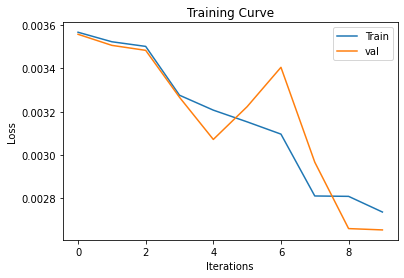

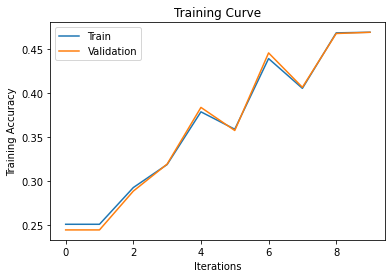

Final Training Accuracy: 0.46926051064126234
Final Validation Accuracy: 0.46921147952075787


In [ ]:
use_cuda = True
model1 = CNNalex()

if use_cuda and torch.cuda.is_available():
  model1.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(model1, tData, vData, batch_size = 500, lr= 0.01, num_epochs=10)


Epoch 0
Epoch:  0  Train Accuracy:  0.48671148420355986
Epoch:  0  Validation Accuracy:  0.48537196990805237
Epoch 1
Epoch:  1  Train Accuracy:  0.4928419659340277
Epoch:  1  Validation Accuracy:  0.48927277793257173
Epoch 2
Epoch:  2  Train Accuracy:  0.49928593820753076
Epoch:  2  Validation Accuracy:  0.49233769852326553
Epoch 3
Epoch:  3  Train Accuracy:  0.49381726984569296
Epoch:  3  Validation Accuracy:  0.48704374477570356
Epoch 4
Epoch:  4  Train Accuracy:  0.5074018600438887
Epoch:  4  Validation Accuracy:  0.5023683477291725
Epoch 5
Epoch:  5  Train Accuracy:  0.5074366923264482
Epoch:  5  Validation Accuracy:  0.5004179437169128
Epoch 6
Epoch:  6  Train Accuracy:  0.5171897314431014
Epoch:  6  Validation Accuracy:  0.5126776260796879
Epoch 7
Epoch:  7  Train Accuracy:  0.5023163467902052
Epoch:  7  Validation Accuracy:  0.5037614934522151
Epoch 8
Epoch:  8  Train Accuracy:  0.5176077188338152
Epoch:  8  Validation Accuracy:  0.5146280300919476
Epoch 9
Epoch:  9  Train Accur

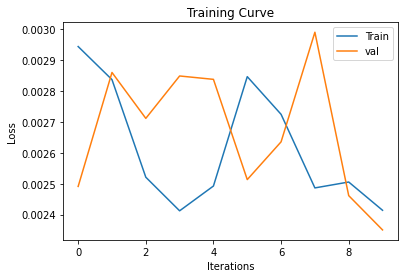

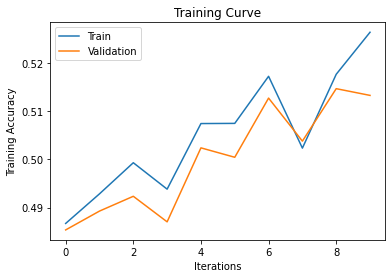

Final Training Accuracy: 0.5263157894736842
Final Validation Accuracy: 0.513234884368905


In [ ]:
train2(model1, tData, vData, batch_size = 500, lr= 0.005, num_epochs=10)

Epoch 0
Epoch:  0  Train Accuracy:  0.528719216970288
Epoch:  0  Validation Accuracy:  0.5188074672610755
Epoch 1
Epoch:  1  Train Accuracy:  0.5237730328468424
Epoch:  1  Validation Accuracy:  0.51797157982725
Epoch 2
Epoch:  2  Train Accuracy:  0.5157267755756034
Epoch:  2  Validation Accuracy:  0.5043187517414321
Epoch 3
Epoch:  3  Train Accuracy:  0.5373576230450381
Epoch:  3  Validation Accuracy:  0.5224296461409863
Epoch 4
Epoch:  4  Train Accuracy:  0.5395520568462852
Epoch:  4  Validation Accuracy:  0.5215937587071607
Epoch 5
Epoch:  5  Train Accuracy:  0.544080253579017
Epoch:  5  Validation Accuracy:  0.5338534410699359
Epoch 6
Epoch:  6  Train Accuracy:  0.5466578424884183
Epoch:  6  Validation Accuracy:  0.5358038450821956
Epoch 7
Epoch:  7  Train Accuracy:  0.5504893935699606
Epoch:  7  Validation Accuracy:  0.5355252159375871
Epoch 8
Epoch:  8  Train Accuracy:  0.5497927479187711
Epoch:  8  Validation Accuracy:  0.5413764279743661
Epoch 9
Epoch:  9  Train Accuracy:  0.547

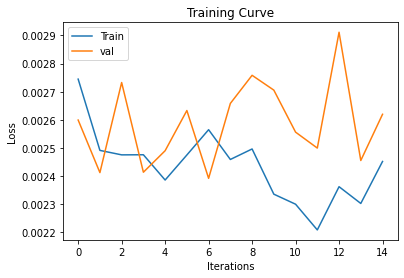

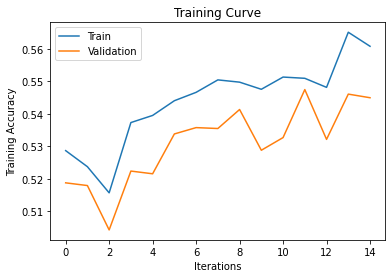

Final Training Accuracy: 0.560834581490125
Final Validation Accuracy: 0.5449986068542769


In [ ]:
train2(model1, tData, vData, batch_size = 500, lr= 0.005, num_epochs=15)

Epoch 0
Epoch:  0  Train Accuracy:  0.5656066042007732
Epoch:  0  Validation Accuracy:  0.5424909445528002
Epoch 1
Epoch:  1  Train Accuracy:  0.549270263680379
Epoch:  1  Validation Accuracy:  0.5277235998885483
Epoch 2
Epoch:  2  Train Accuracy:  0.5692988261520777
Epoch:  2  Validation Accuracy:  0.5427695736974087
Epoch 3
Epoch:  3  Train Accuracy:  0.5599637744261381
Epoch:  3  Validation Accuracy:  0.5282808581777654
Epoch 4
Epoch:  4  Train Accuracy:  0.5722595701696332
Epoch:  4  Validation Accuracy:  0.5452772359988854
Epoch 5
Epoch:  5  Train Accuracy:  0.5531714793270402
Epoch:  5  Validation Accuracy:  0.5338534410699359
Epoch 6
Epoch:  6  Train Accuracy:  0.5773799157058762
Epoch:  6  Validation Accuracy:  0.5416550571189747
Epoch 7
Epoch:  7  Train Accuracy:  0.5748371590790344
Epoch:  7  Validation Accuracy:  0.5483421565895793
Epoch 8
Epoch:  8  Train Accuracy:  0.5801316660280749
Epoch:  8  Validation Accuracy:  0.5500139314572304
Epoch 9
Epoch:  9  Train Accuracy:  0.

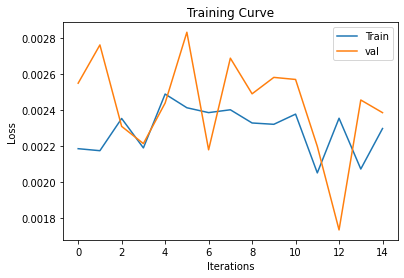

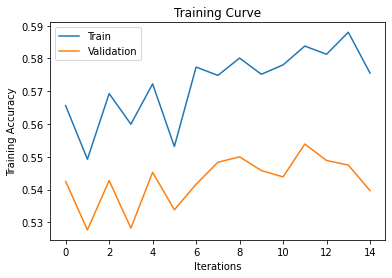

Final Training Accuracy: 0.575533804730224
Final Validation Accuracy: 0.539704653106715


In [ ]:
train2(model1, tData, vData, batch_size = 500, lr= 0.005, num_epochs=15)

Epoch 0
Epoch:  0  Train Accuracy:  0.5955623672019228
Epoch:  0  Validation Accuracy:  0.5586514349400947
Epoch 1
Epoch:  1  Train Accuracy:  0.5984186143717998
Epoch:  1  Validation Accuracy:  0.5603232098077459
Epoch 2
Epoch:  2  Train Accuracy:  0.5982444529590024
Epoch:  2  Validation Accuracy:  0.5575369183616606
Epoch 3
Epoch:  3  Train Accuracy:  0.5982792852415619
Epoch:  3  Validation Accuracy:  0.5617163555307885
Epoch 4
Epoch:  4  Train Accuracy:  0.5987321049148351
Epoch:  4  Validation Accuracy:  0.5586514349400947
Epoch 5
Epoch:  5  Train Accuracy:  0.598801769479954
Epoch:  5  Validation Accuracy:  0.5583728057954862
Epoch 6
Epoch:  6  Train Accuracy:  0.5999860670869762
Epoch:  6  Validation Accuracy:  0.5583728057954862
Epoch 7
Epoch:  7  Train Accuracy:  0.6008220418684036
Epoch:  7  Validation Accuracy:  0.5603232098077459
Epoch 8
Epoch:  8  Train Accuracy:  0.6000905639346547
Epoch:  8  Validation Accuracy:  0.5597659515185288
Epoch 9
Epoch:  9  Train Accuracy:  0.

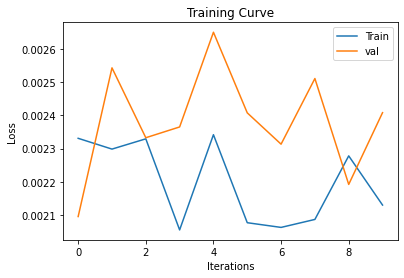

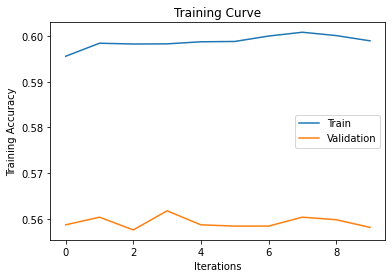

Final Training Accuracy: 0.598941098610192
Final Validation Accuracy: 0.5580941766508777


In [ ]:
train2(model1, tData, vData, batch_size = 500, lr= 0.001, num_epochs=10)

In [ ]:
use_cuda = True
model2 = CNNalex()

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(model2, tData, vData, batch_size = 500, lr= 0.01, num_epochs=100)

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.38169215228673936
Epoch:  0  Validation Accuracy:  0.3839509612705489
Epoch 1
Epoch:  1  Train Accuracy:  0.4892194085478421
Epoch:  1  Validation Accuracy:  0.47952075787127335
Epoch 2
Epoch:  2  Train Accuracy:  0.5304956633808213
Epoch:  2  Validation Accuracy:  0.5162998049595988
Epoch 3
Epoch:  3  Train Accuracy:  0.573339370928977
Epoch:  3  Validation Accuracy:  0.5444413485650599
Epoch 4
Epoch:  4  Train Accuracy:  0.5843463722177714
Epoch:  4  Validation Accuracy:  0.545555865143494
Epoch 5
Epoch:  5  Train Accuracy:  0.6121077014176739
Epoch:  5  Validation Accuracy:  0.5536361103371412
Epoch 6
Epoch:  6  Train Accuracy:  0.6252743042251558
Epoch:  6  Validation Accuracy:  0.5578155475062692
Epoch 7
Epoch:  7  Train Accuracy:  0.668083179490752
Epoch:  7  Validation Accuracy:  0.5606018389523544
Epoch 8
Epoch:  8  Train Accuracy:  0.6968894771674388
Epoch:  8  Validation Accuracy:  0.561994984675397

KeyboardInterrupt: ignored

# apr 3
first model, increase weight decay, smaller batch size

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.4471071789334355
Epoch:  0  Validation Accuracy:  0.4460852605182502
Epoch 1
Epoch:  1  Train Accuracy:  0.5163189243791145
Epoch:  1  Validation Accuracy:  0.49568124825856785
Epoch 2
Epoch:  2  Train Accuracy:  0.5566198753004284
Epoch:  2  Validation Accuracy:  0.5307885204792421
Epoch 3
Epoch:  3  Train Accuracy:  0.6063952070779198
Epoch:  3  Validation Accuracy:  0.5572582892170521
Epoch 4
Epoch:  4  Train Accuracy:  0.6007523773032847
Epoch:  4  Validation Accuracy:  0.546113123432711
Epoch 5
Epoch:  5  Train Accuracy:  0.6624055174335575
Epoch:  5  Validation Accuracy:  0.5728615213151296
Epoch 6
Epoch:  6  Train Accuracy:  0.5413981678219374
Epoch:  6  Validation Accuracy:  0.4714405126776261
Epoch 7
Epoch:  7  Train Accuracy:  0.7464558152495733
Epoch:  7  Validation Accuracy:  0.5809417665087768
Epoch 8
Epoch:  8  Train Accuracy:  0.7290048416872758
Epoch:  8  Validation Accuracy:  0.56255224296461

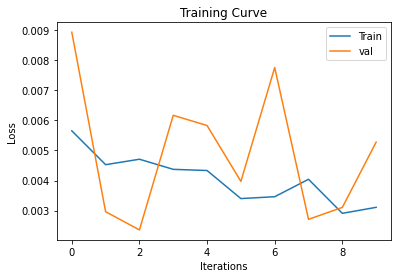

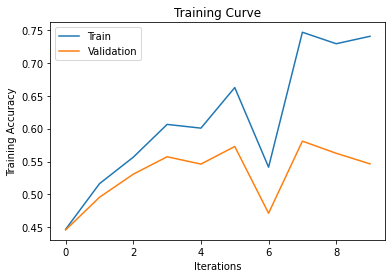

Final Training Accuracy: 0.7403253335191055
Final Validation Accuracy: 0.5463917525773195


In [ ]:
use_cuda = True
model3 = CNNalex()

if use_cuda and torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(model3, tData, vData, batch_size = 256, lr= 0.01, num_epochs=10)

Epoch 0
Epoch:  0  Train Accuracy:  0.7751924483611411
Epoch:  0  Validation Accuracy:  0.5661744218445249
Epoch 1
Epoch:  1  Train Accuracy:  0.7860252882371381
Epoch:  1  Validation Accuracy:  0.5266090833101142
Epoch 2
Epoch:  2  Train Accuracy:  0.845344665435926
Epoch:  2  Validation Accuracy:  0.5530788520479242
Epoch 3
Epoch:  3  Train Accuracy:  0.8452750008708071
Epoch:  3  Validation Accuracy:  0.5525215937587071
Epoch 4
Epoch:  4  Train Accuracy:  0.8927165697168136
Epoch:  4  Validation Accuracy:  0.5759264419058233
Epoch 5
Epoch:  5  Train Accuracy:  0.8240969730746456
Epoch:  5  Validation Accuracy:  0.5202006129841181
Epoch 6
Epoch:  6  Train Accuracy:  0.9100282141488731
Epoch:  6  Validation Accuracy:  0.566731680133742
Epoch 7
Epoch:  7  Train Accuracy:  0.9074157929569124
Epoch:  7  Validation Accuracy:  0.5569796600724436
Epoch 8
Epoch:  8  Train Accuracy:  0.8648507436692326
Epoch:  8  Validation Accuracy:  0.556143772638618
Epoch 9
Epoch:  9  Train Accuracy:  0.91

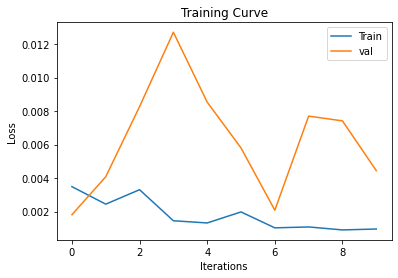

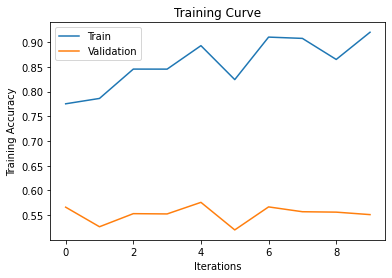

Final Training Accuracy: 0.9198509178306454
Final Validation Accuracy: 0.5511284480356645


In [ ]:
train2(model3, tData, vData, batch_size = 256, lr= 0.01, num_epochs=10)

Epoch 0
Epoch:  0  Train Accuracy:  0.9935211954439375
Epoch:  0  Validation Accuracy:  0.5965449986068543
Epoch 1
Epoch:  1  Train Accuracy:  0.9954718032672681
Epoch:  1  Validation Accuracy:  0.5984954026191139
Epoch 2
Epoch:  2  Train Accuracy:  0.9963774426138144
Epoch:  2  Validation Accuracy:  0.5987740317637225
Epoch 3
Epoch:  3  Train Accuracy:  0.9968999268522066
Epoch:  3  Validation Accuracy:  0.5993312900529395
Epoch 4
Epoch:  4  Train Accuracy:  0.9973179142429204
Epoch:  4  Validation Accuracy:  0.5976595151852884
Epoch 5
Epoch:  5  Train Accuracy:  0.9974572433731582
Epoch:  5  Validation Accuracy:  0.5948732237392031
Epoch 6
Epoch:  6  Train Accuracy:  0.9979100630464315
Epoch:  6  Validation Accuracy:  0.6012816940651993
Epoch 7
Epoch:  7  Train Accuracy:  0.9977010693510746
Epoch:  7  Validation Accuracy:  0.5987740317637225
Epoch 8
Epoch:  8  Train Accuracy:  0.9983280504371451
Epoch:  8  Validation Accuracy:  0.6004458066313736
Epoch 9
Epoch:  9  Train Accuracy:  0

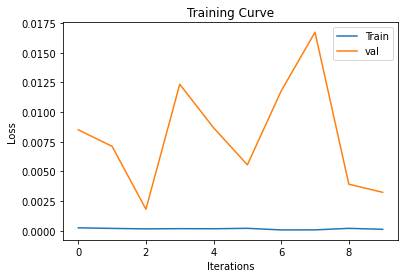

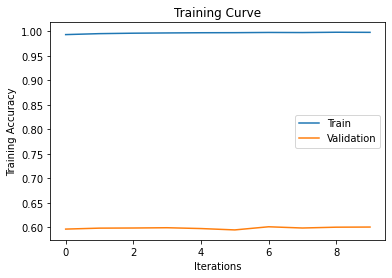

Final Training Accuracy: 0.9981190567417882
Final Validation Accuracy: 0.6007244357759821


In [ ]:
train2(model3, tData, vData, batch_size = 256, lr= 0.001, num_epochs=10)

# apr 3
2nd train, earlier adaptive lr

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.4705841373785224
Epoch:  0  Validation Accuracy:  0.4683755920869323
Epoch 1
Epoch:  1  Train Accuracy:  0.5323417743564736
Epoch:  1  Validation Accuracy:  0.5135135135135135
Epoch 2
Epoch:  2  Train Accuracy:  0.5588491413842349
Epoch:  2  Validation Accuracy:  0.5299526330454165
Epoch 3
Epoch:  3  Train Accuracy:  0.5939949144867464
Epoch:  3  Validation Accuracy:  0.5553078852047925
Epoch 4
Epoch:  4  Train Accuracy:  0.6091469574001185
Epoch:  4  Validation Accuracy:  0.5536361103371412
Epoch 5
Epoch:  5  Train Accuracy:  0.6333553937789543
Epoch:  5  Validation Accuracy:  0.5583728057954862
Epoch 6
Epoch:  6  Train Accuracy:  0.671810233724616
Epoch:  6  Validation Accuracy:  0.5692393424352187
Epoch 7
Epoch:  7  Train Accuracy:  0.6715315754641402
Epoch:  7  Validation Accuracy:  0.5458344942881025
Epoch 8
Epoch:  8  Train Accuracy:  0.7248249677801386
Epoch:  8  Validation Accuracy:  0.571468375592087

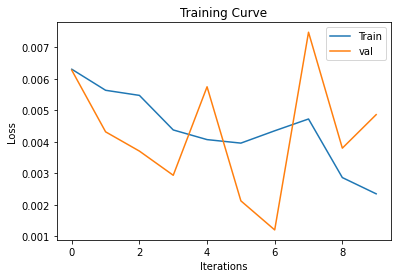

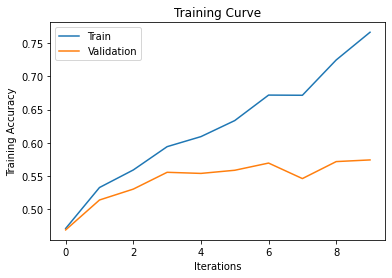

Final Training Accuracy: 0.7666237068515099
Final Validation Accuracy: 0.5739760378935637


In [ ]:
use_cuda = True
model5 = CNNalex()

if use_cuda and torch.cuda.is_available():
  model5.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(model5, tData, vData, batch_size = 256, lr= 0.01, num_epochs=10)

Epoch 0
Epoch:  0  Train Accuracy:  0.8529729353164512
Epoch:  0  Validation Accuracy:  0.5873502368347729
Epoch 1
Epoch:  1  Train Accuracy:  0.8732453237660663
Epoch:  1  Validation Accuracy:  0.5859570911117303
Epoch 2
Epoch:  2  Train Accuracy:  0.8873523982026542
Epoch:  2  Validation Accuracy:  0.5870716076901644
Epoch 3
Epoch:  3  Train Accuracy:  0.9014246403566826
Epoch:  3  Validation Accuracy:  0.5834494288102535
Epoch 4
Epoch:  4  Train Accuracy:  0.905987669371974
Epoch:  4  Validation Accuracy:  0.5856784619671218
Epoch 5
Epoch:  5  Train Accuracy:  0.9227768295656414
Epoch:  5  Validation Accuracy:  0.5851212036779047
Epoch 6
Epoch:  6  Train Accuracy:  0.9316242293357484
Epoch:  6  Validation Accuracy:  0.5867929785455559
Epoch 7
Epoch:  7  Train Accuracy:  0.9424222369291859
Epoch:  7  Validation Accuracy:  0.5845639453886876
Epoch 8
Epoch:  8  Train Accuracy:  0.9499808422445923
Epoch:  8  Validation Accuracy:  0.5859570911117303
Epoch 9
Epoch:  9  Train Accuracy:  0.

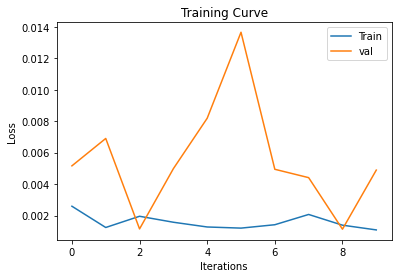

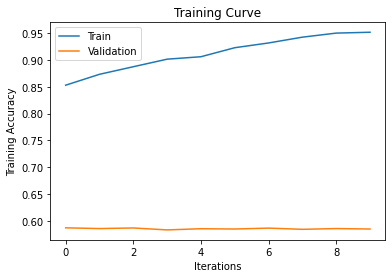

Final Training Accuracy: 0.9515831272423282
Final Validation Accuracy: 0.5851212036779047


In [ ]:
train2(model5, tData, vData, batch_size = 256, lr= 0.001, num_epochs=10)

# apr3 3rd
new model add conv

In [ ]:
# Modified from Tutorial 3a and lecture notes
class CNNalex2(nn.Module):
    def __init__(self):
        super(CNNalex2, self).__init__()
        # nn.Conv2d(256,300,5,2)
        self.conv1 = nn.Conv2d(256,300,3, padding = 2) # Modified to 3, in_channels, out_chanels, kernel_size
        self.conv2 = nn.Conv2d(300,300,3)
        self.conv3 = nn.Conv2d(300,300,1)

        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.fc1 = nn.Linear(300*2*2, 32) # Modified first parameter
        self.fc2 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 4
        x = (F.relu(self.conv2(x))) #2
        x = (F.relu(self.conv3(x)))
        x = x.view(-1, 300*2*2) # Modified size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
use_cuda = True
model6 = CNNalex2()

if use_cuda and torch.cuda.is_available():
  model6.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(model6, tData, vData, batch_size = 256, lr= 0.01, num_epochs=10) #weightdecaty = 5e-3

CUDA is available!  Training on GPU ...
Epoch 0


FileNotFoundError: ignored

Epoch 0


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch:  0  Train Accuracy:  0.784910655195235
Epoch:  0  Validation Accuracy:  0.5926441905823349
Epoch 1


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  1  Train Accuracy:  0.8085966073356787
Epoch:  1  Validation Accuracy:  0.588464753413207
Epoch 2


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  2  Train Accuracy:  0.8245149604653593
Epoch:  2  Validation Accuracy:  0.5906937865700752
Epoch 3


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  3  Train Accuracy:  0.84241875370093
Epoch:  3  Validation Accuracy:  0.5890220117024241
Epoch 4


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  4  Train Accuracy:  0.8500470235814553
Epoch:  4  Validation Accuracy:  0.5923655614377263
Epoch 5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  5  Train Accuracy:  0.8633181232366157
Epoch:  5  Validation Accuracy:  0.5881861242685985
Epoch 6


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  6  Train Accuracy:  0.8872827336375353
Epoch:  6  Validation Accuracy:  0.5856784619671218
Epoch 7


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  7  Train Accuracy:  0.9021212860078721
Epoch:  7  Validation Accuracy:  0.5789913624965172
Epoch 8


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  8  Train Accuracy:  0.9109338534954196
Epoch:  8  Validation Accuracy:  0.5851212036779047
Epoch 9


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe5bb1ca950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch:  9  Train Accuracy:  0.924135288585461
Epoch:  9  Validation Accuracy:  0.5834494288102535


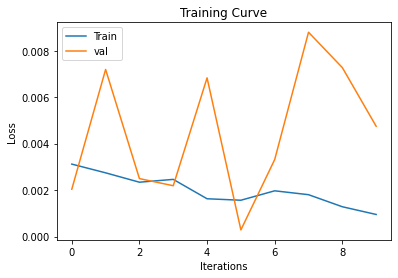

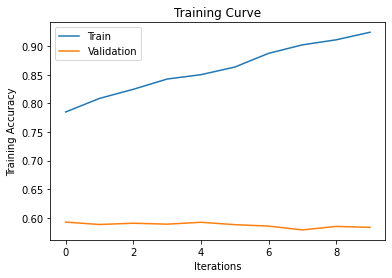

Final Training Accuracy: 0.924135288585461
Final Validation Accuracy: 0.5834494288102535


In [ ]:
train2(model6, tData, vData, batch_size = 256, lr= 0.001, num_epochs=10,weight_decay=1e-3)

# apr 3 new model resnet

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [7]:
resnet18new2 = torchvision.models.resnet.resnet18(pretrained=True)

In [8]:
num_feature = resnet18new2.fc.in_features
resnet18new2.fc=nn.Linear(num_feature, 6)

In [6]:
parent_path = '/content/drive/MyDrive/APS360 Team/Alex_Uploads/FER-2013_Images/FER-2013/'

data_transform = transforms.Compose(
    [
        transforms.Resize((224,224)), 
        #convert image to grayscale
        # transforms.Grayscale(num_output_channels=3),
        #randomly adding brightness 
        # transforms.ColorJitter(brightness=(1,1.2)),
        #apply ramdom rotation from -30 to 30 degrees
        # transforms.RandomRotation(30),
        #apply random horizontal flip with probability of 50% 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        #normalize the data with 0.5 mean and variance.
        transforms.Normalize((0.5073955,), (0.25,), inplace=True)
       
    ])
training_set = torchvision.datasets.ImageFolder(parent_path+'train',data_transform)
valid_set = torchvision.datasets.ImageFolder(parent_path+'valid',data_transform)

# train_data = datasets.DatasetFolder(parent_path+'train', loader=torch.load, extensions=('.tensor'))
# val_data = datasets.DatasetFolder(parent_path+'val', loader=torch.load, extensions=('.tensor'))
# train_data = train_data.view(3,224,224)
# val_data = val_data.view(3,224,224)

In [ ]:
# torch.cuda.empty_cache()



CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.6338368997822104
Epoch:  0  Validation Accuracy:  0.6040679855112845
Epoch 1
Epoch:  1  Train Accuracy:  0.7146610433159332
Epoch:  1  Validation Accuracy:  0.6427974366118696
Epoch 2
Epoch:  2  Train Accuracy:  0.7540705914889204
Epoch:  2  Validation Accuracy:  0.6503204235162998
Epoch 3
Epoch:  3  Train Accuracy:  0.7980087807238911
Epoch:  3  Validation Accuracy:  0.6581220395653385
Epoch 4
Epoch:  4  Train Accuracy:  0.836070107512013
Epoch:  4  Validation Accuracy:  0.6720534967957649


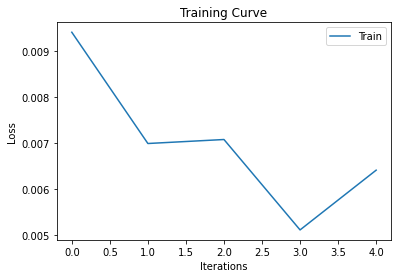

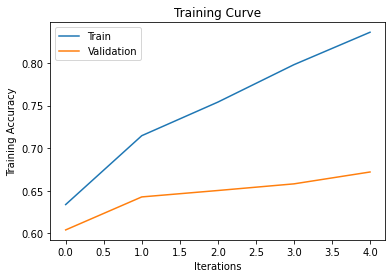

Final Training Accuracy: 0.836070107512013
Final Validation Accuracy: 0.6720534967957649


In [ ]:

use_cuda = True


if use_cuda and torch.cuda.is_available():
  resnet18new2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(resnet18new2, training_set, valid_set, batch_size = 128, lr= 0.01, num_epochs=5,weight_decay=5e-4)

In [ ]:
path = '/content/drive/MyDrive/APS360 Team/model checkpoint/res.pth'
torch.save(resnet18new2.state_dict(), path)

In [ ]:
train2(resnet18new2, training_set, valid_set, batch_size = 128, lr= 0.001, num_epochs=5,weight_decay=5e-4)

Epoch 0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.6557860376961145
Epoch:  0  Validation Accuracy:  0.6165817770232032
Epoch 1
Epoch:  1  Train Accuracy:  0.7007476045066863
Epoch:  1  Validation Accuracy:  0.6525183927560838
Epoch 2
Epoch:  2  Train Accuracy:  0.747042925836229
Epoch:  2  Validation Accuracy:  0.669779286926995
Epoch 3
Epoch:  3  Train Accuracy:  0.7916184058123618
Epoch:  3  Validation Accuracy:  0.6595925297113752
Epoch 4
Epoch:  4  Train Accuracy:  0.830297286862518
Epoch:  4  Validation Accuracy:  0.6612903225806451
Epoch 5
Epoch:  5  Train Accuracy:  0.8632199641992208
Epoch:  5  Validation Accuracy:  0.666383701188455
Epoch 6
Epoch:  6  Train Accuracy:  0.8707311080692148
Epoch:  6  Validation Accuracy:  0.6683644595359366
Epoch 7
Epoch:  7  Train Accuracy:  0.897932680495595
Epoch:  7  Validation Accuracy:  0.6598754951895869
Epoch 8
Epoch:  8  Train Accuracy:  0.9064616896563827
Epoch:  8  Validation Accuracy:  0.6561969439728353
Ep

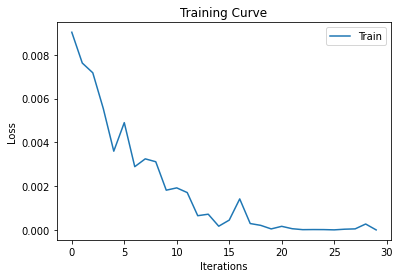

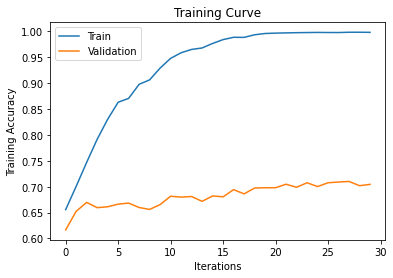

Final Training Accuracy: 0.9983152574497209
Final Validation Accuracy: 0.7045840407470289


In [7]:

resnet18new3 = torchvision.models.resnet.resnet18(pretrained=True)
num_feature = resnet18new3.fc.in_features
resnet18new3.fc=nn.Linear(num_feature, 6)


use_cuda = True



if use_cuda and torch.cuda.is_available():
  resnet18new3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2(resnet18new3, training_set, valid_set, batch_size = 128, lr= 0.01, num_epochs=30,weight_decay=5e-4)

In [8]:
path = '/content/drive/MyDrive/APS360 Team/model checkpoint/res_with_learning_rate_schedualer.pth'
torch.save(resnet18new3.state_dict(), path)

In [12]:
def train2_resample(model, train_data, val_data, batch_size=3000, num_epochs=5, lr = 0.01,weight_decay = 5e-3):
    
    num_workers = 1
    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices_train = list(range(num_train))
    np.random.shuffle(indices_train)
    num_val = len(val_data)
    indices_val = list(range(num_val))
    np.random.shuffle(indices_val)
    '''
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    '''

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(indices_train)
    valid_sampler = SubsetRandomSampler(indices_val)

    train_loader = torch.utils.data.DataLoader(
    train_data,
    #sampler=ImbalancedDatasetSampler(train_data),
    sampler = train_sampler,
    batch_size=batch_size,
    num_workers = num_workers,
    #shuffle = True
    )

    val_loader = torch.utils.data.DataLoader(
    val_data,
    #sampler=ImbalancedDatasetSampler(train_data),
    sampler = valid_sampler,
    batch_size=batch_size,
    num_workers = num_workers,
    #shuffle = True
    )



    '''
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
    '''
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay = weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',verbose=True, factor=0.9,patience=3)

    iters, losses, train_acc, val_acc, val_loss = [], [], [], [],[]

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print("Epoch", epoch)
        n = 0
        for imgs, labels in iter(train_loader):
            # print("iteration ", n)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            n += 1

        for imgs, labels in iter(val_loader):
            # print("iteration ", n)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)             # forward pass

            loss_val = criterion(out, labels) # compute the total loss
        
        scheduler.step(loss_val)
        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        val_loss.append(float(loss_val)/batch_size)
       # calculate accuracy at each epoch instead of iteration
       # def get_accuracy(model, data):
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        # compute validation acc every epoch
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print("Epoch: ", epoch, " Train Accuracy: ", train_acc[epoch])
        print("Epoch: ", epoch, " Validation Accuracy: ", val_acc[epoch])

            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    # plt.plot(iters, val_loss, label="val")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 0
Epoch:  0  Train Accuracy:  0.6322698395984697
Epoch:  0  Validation Accuracy:  0.6123372948500283
Epoch 1
Epoch:  1  Train Accuracy:  0.7099785897300902
Epoch:  1  Validation Accuracy:  0.6437464629315224
Epoch 2
Epoch:  2  Train Accuracy:  0.7561335158471096
Epoch:  2  Validation Accuracy:  0.655631013016412
Epoch 3
Epoch:  3  Train Accuracy:  0.760766557860377
Epoch:  3  Validation Accuracy:  0.656479909451047
Epoch 4
Epoch:  4  Train Accuracy:  0.8167140500508933
Epoch:  4  Validation Accuracy:  0.6491228070175439
Epoch 5
Epoch:  5  Train Accuracy:  0.8654311887964621
Epoch:  5  Validation Accuracy:  0.668081494057725
Epoch 6
Epoch     7: reducing learning rate of group 0 to 9.0000e-03.
Epoch:  6  Train Accuracy:  0.8622722965146888
Epoch:  6  Validation Accuracy:  0.6397849462365591
Epoch 7
Epoch:  7  Train Accuracy:  0.9162542557298796
Epoch:  7  Validation Accuracy:  0.66723259762309
Epoch 8
Epoch:  8  Train Accuracy:  0.9080762346

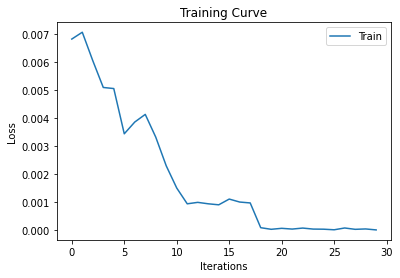

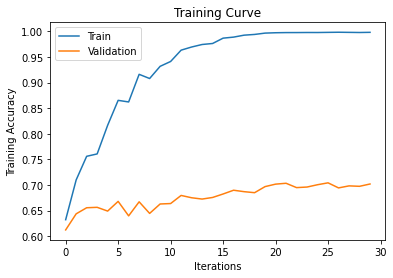

Final Training Accuracy: 0.9982801586465901
Final Validation Accuracy: 0.702037351443124


In [13]:
resnet18new4 = torchvision.models.resnet.resnet18(pretrained=True)
num_feature = resnet18new4.fc.in_features
resnet18new4.fc=nn.Linear(num_feature, 6)


use_cuda = True



if use_cuda and torch.cuda.is_available():
  resnet18new4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train2_resample(resnet18new4, training_set, valid_set, batch_size = 128, lr= 0.01, num_epochs=30,weight_decay=5e-4)

In [14]:
path = '/content/drive/MyDrive/APS360 Team/model checkpoint/res_with_learning_rate_schedualer_resample.pth'
torch.save(resnet18new4.state_dict(), path)